In [1]:
from dask.distributed import Client as dask_client
from matplotlib.colors import ListedColormap
from pystac_client import Client
from pystac.extensions.raster import RasterExtension as raster
from pystac.extensions.projection import ProjectionExtension as proj

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer as pc
import rasterio
import rasterio.features
import stackstac

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [            
            [ 178.478431, -17.6426563 ], 
            [ 178.4875358, -17.6427653 ], 
            [ 178.5163223, -17.6076001 ], 
            [ 178.5020381, -17.6065642 ], 
            [ 178.478431, -17.6426563 ],
        ]
    ],
}

In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(collections=["io-lulc"], intersects=area_of_interest)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


In [4]:
item = next(search.get_items())
epsg = proj.ext(item).epsg
nodata = raster.ext(item.assets["data"]).bands[0].nodata
items = [pc.sign(item).to_dict() for item in search.get_items()]
bounds_latlon = rasterio.features.bounds(area_of_interest)

# Create a single DataArray from out multiple resutls with the corresponding
# rasters projected to a single CRS. Note that we set the dtype to ubyte, which
# matches our data, since stackstac will use float64 by default.
stack = stackstac.stack(
    items, epsg=epsg, dtype=np.ubyte, fill_value=nodata, bounds_latlon=bounds_latlon
)

stack

<xarray.DataArray 'stackstac-83a661ed20f67615d585246dc8fd8cbb' (time: 1, band: 1, y: 404, x: 406)>
dask.array<fetch_raster_window, shape=(1, 1, 404, 406), dtype=uint8, chunksize=(1, 1, 404, 406), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * time               (time) datetime64[ns] 2020-06-01
    id                 (time) <U8 '60K-2020'
  * band               (band) <U4 'data'
  * x                  (x) float64 6.568e+05 6.568e+05 ... 6.609e+05 6.609e+05
  * y                  (y) float64 8.053e+06 8.053e+06 ... 8.049e+06 8.049e+06
    proj:bbox          object {841600.2521048393, 7864419.112077935, 476100.2...
    ...                 ...
    label:classes      object {'name': '', 'classes': ['nodata', 'water', 'tr...
    label:properties   object None
    label:description  <U4 'lulc'
    proj:shape         object {36550, 35670}
    raster:bands       object {'nodata': 0, 'spatial_resolution': 10}
    epsg               int64 32760
Attributes:
    spec:        RasterSpec(epsg=32760, bounds=(656830.0, 8048690.0, 660890.0...
    crs:         epsg:32760
    transform:   | 10.00, 0.00, 656830.00|\n| 0.00,-10.00, 8052730.00|\n| 0.0...
    resolution:  10.0

In [5]:
client = dask_client(processes=False)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


In [6]:
merged = stackstac.mosaic(stack, dim="time", axis=None).squeeze().compute()
merged

<xarray.DataArray 'stackstac-83a661ed20f67615d585246dc8fd8cbb' (y: 404, x: 406)>
array([[2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)
Coordinates: (12/16)
    band               <U4 'data'
  * x                  (x) float64 6.568e+05 6.568e+05 ... 6.609e+05 6.609e+05
  * y                  (y) float64 8.053e+06 8.053e+06 ... 8.049e+06 8.049e+06
    proj:bbox          object {841600.2521048393, 7864419.112077935, 476100.2...
    io:supercell_id    <U3 '60K'
    proj:epsg          int64 32760
    ...                 ...
    label:classes      object {'name': '', 'classes': ['nodata', 'water', 'tr...
    label:properties   object None
    label:description  <U4 'lulc'
    proj:shape         object {36550, 35670}
    raster:bands       object {'nodata': 0, 'spatial_resolution': 10}
    epsg               int64 32760
Attributes:
    spec:        RasterSpec(epsg=32760, bounds=(656830.0, 8048690.0, 660890.0...
    crs:         epsg:32760
    transform:   | 10.00, 0.00, 656830.00|\n| 0.00,-10.00, 8052730.00|\n| 0.0...
    resolution:  10.0

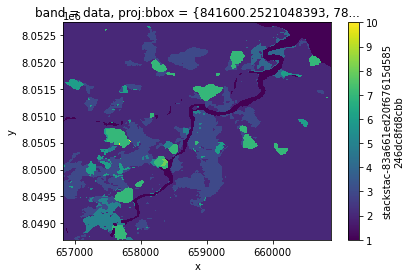

In [7]:
merged.plot()
plt.show()

In [8]:
class_names = merged.coords["label:classes"].item()["classes"]
class_count = len(class_names)

with rasterio.open(pc.sign(item.assets["data"].href)) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [
        np.array(colormap_def[i]) / 255 for i in range(class_count)
    ]  # transform to matplotlib color format

cmap = ListedColormap(colormap)

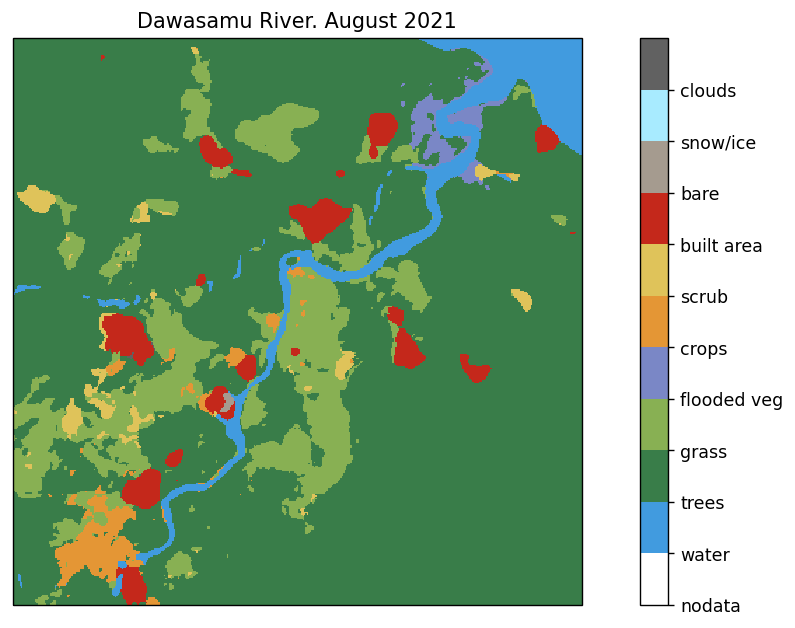

In [10]:
fig, ax = plt.subplots(
    figsize=(12, 6), dpi=125, subplot_kw=dict(projection=ccrs.epsg(epsg)), frameon=False
)
p = merged.plot(
    ax=ax,
    transform=ccrs.epsg(epsg),
    cmap=cmap,
    add_colorbar=False,
    vmin=0,
    vmax=class_count,
)
ax.set_title("Dawasamu River. August 2021")

cbar = plt.colorbar(p)
cbar.set_ticks(range(class_count))
cbar.set_ticklabels(class_names)